In [1]:
import io
import requests

from PIL import Image as im

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:


oid = 'ZTF18acckcza'

r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': oid,
    'withupperlim': 'True',
  }
)

# Format output in a DataFrame
pdf_magpsf = pd.read_json(io.BytesIO(r.content))



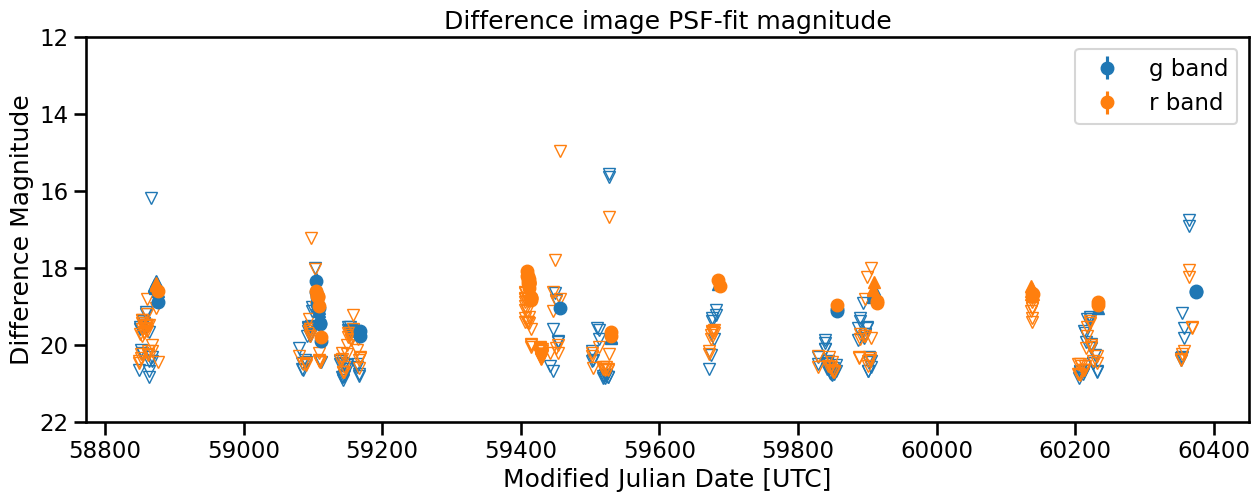

In [3]:


mjd = pdf_magpsf['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf['i:fid']):
    maskFilt = pdf_magpsf['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_magpsf['d:tag'] == 'valid'
    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    maskUpper = pdf_magpsf['d:tag'] == 'upperlim'
    plt.plot(
        pdf_magpsf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='v', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf_magpsf['d:tag'] == 'badquality'
    plt.errorbar(
        pdf_magpsf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskBadquality & maskFilt]['i:magpsf'],
        pdf_magpsf[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='^', color=colordic[filt]
    )

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



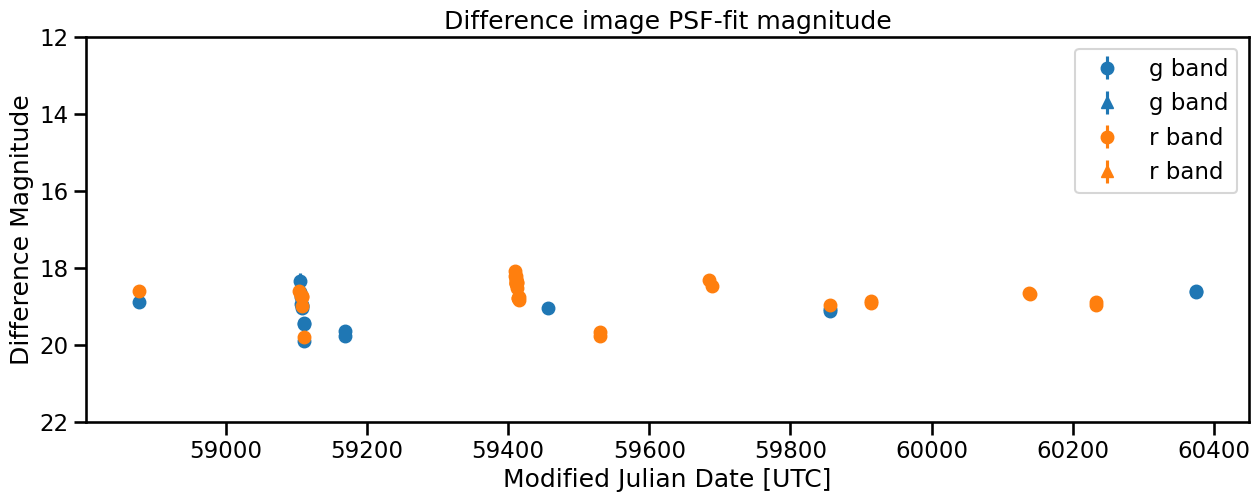

In [4]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf['i:fid']):
    maskFilt = pdf_magpsf['i:fid'] == filt
    # The column `d:tag` is used to check data type
    maskValid = pdf_magpsf['d:tag'] == 'valid' 
    maskneg = pdf_magpsf['i:isdiffpos'] == 't' 

    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )
    maskpos = pdf_magpsf['i:isdiffpos'] == 'f' 

    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:sigmapsf'],
        ls = '', marker='^', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )
    
    
    #pa pratique !
    maskUpper = pdf_magpsf['d:tag'] == 'upperlim'
    #plt.plot(pdf_magpsf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
    #pdf_magpsf[maskUpper & maskFilt]['i:diffmaglim'],ls='', marker='o', color=colordic[filt],  )

    maskBadquality = pdf_magpsf['d:tag'] == 'badquality'
    #plt.errorbar(
    #    pdf_magpsf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
    #    pdf_magpsf[maskBadquality & maskFilt]['i:magpsf'],
    #    pdf_magpsf[maskBadquality & maskFilt]['i:sigmapsf'],
    #    ls='', marker='o', color=colordic[filt])

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



In [14]:
# from fink_science.conversion import dc_mag
from fink_utils.photometry.conversion import dc_mag
from fink_utils.photometry.utils import is_source_behind

# Take only valid measurements
# pdf_magpsf_valid = pdf_magpsf[pdf_magpsf['d:tag'] == 'valid'].sort_values('i:jd', ascending=False)

df_valid = pdf_magpsf[pdf_magpsf['d:tag'] == 'valid'].sort_values('i:jd', ascending=False)
df_valid['mjd'] = df_valid['i:jd'] - 2400000.5
pdf_magpsf_valid = df_valid#[(df_valid['mjd']>= 59400) & (df_valid['mjd'] <= 59420)]


isSource = is_source_behind(
    pdf_magpsf_valid['i:distnr'].values[0]
)

if isSource:
    print('It looks like there is a source behind. Lets compute the DC magnitude instead.')
    
    # Use DC magnitude instead of difference mag
    mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                pdf_magpsf_valid['i:magpsf'].astype(float).values,
                pdf_magpsf_valid['i:sigmapsf'].astype(float).values,
                pdf_magpsf_valid['i:magnr'].astype(float).values,
                pdf_magpsf_valid['i:sigmagnr'].astype(float).values,
                pdf_magpsf_valid['i:isdiffpos'].values
            )
        ]
    )
    
    pdf_magpsf_valid['i:mag_dc2'] = mag_dc
    pdf_magpsf_valid['i:err_dc2'] = err_dc
else:
    print('No source found -- keeping PSF fit magnitude')
    pdf_magpsf_valid['i:mag_dc2'] = pdf_magpsf_valid['i:magpsf']
    pdf_magpsf_valid['i:err_dc2'] = pdf_magpsf_valid['i:sigmapsf']



No source found -- keeping PSF fit magnitude


In [15]:
pdf_magpsf_valid['i:distnr']


0      10.623923
1      10.864206
18      0.962589
19      1.264779
59      1.241475
65      1.249515
74      1.047248
75      1.249208
113     1.013191
114    10.823056
115    10.610292
148     0.987600
149     0.977088
166     0.989195
167     1.268812
199    10.920635
237     0.918583
238     0.908654
241     0.933979
244     0.914698
245     1.449826
246     1.408168
248     1.285937
249     1.534409
250     1.358766
252     1.364672
253     1.336515
254     1.397928
256     1.486773
257     1.451909
261     1.435363
263     1.391473
273    10.878007
274    10.763827
320     1.031933
321    10.785479
323    10.654679
324    10.885915
331    10.777400
335     1.308173
336     1.394563
337     0.921603
338    10.811421
339    10.871222
340    10.710572
341    10.845635
342     0.921355
343     1.343560
346    10.768940
347    10.965037
348     0.907499
380    10.632939
382     0.932232
Name: i:distnr, dtype: float64

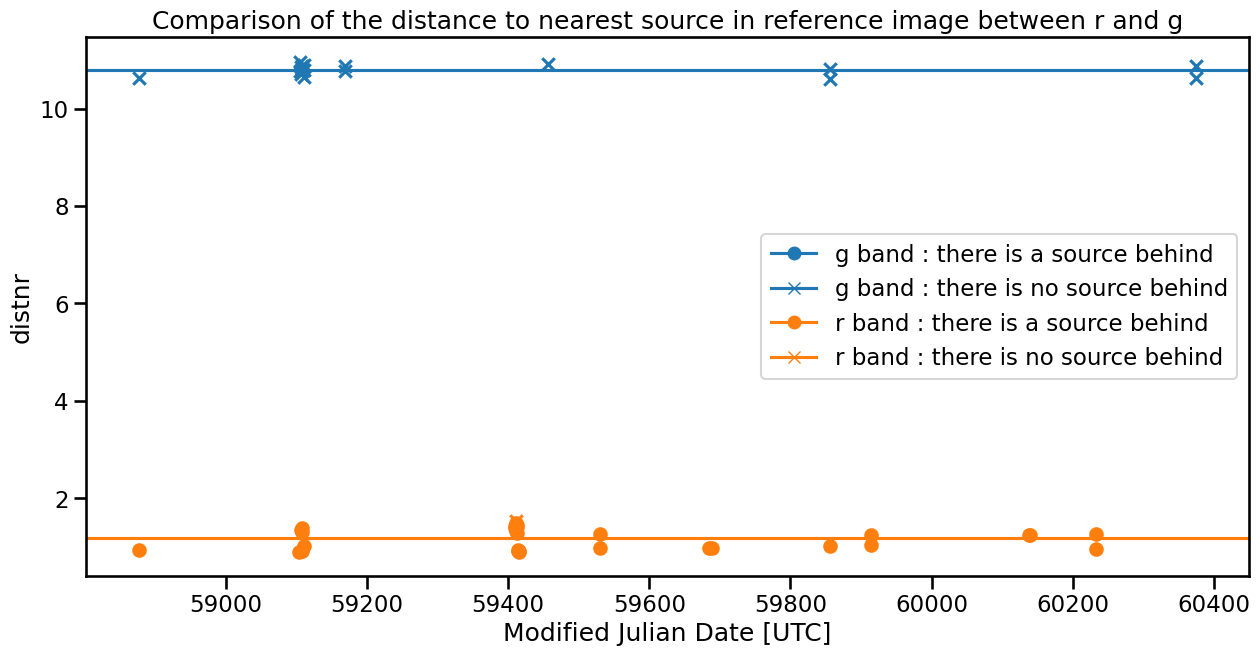

In [6]:
# Take only valid measurements


fig = plt.figure(figsize=(15, 7))
for filt in np.unique(pdf_magpsf['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt
    
#     plt.scatter(df_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
#                 df_valid[maskFilt]['i:distnr'], label='{} band'.format(filtdic[filt]) , marker='*' )
    
#     plt.axhline(df_valid[maskFilt]['i:distnr'].mean(), color=colordic[filt])
    
#     is_Source = is_source_behind(df_valid['i:distnr'])
#     is_Source

    plt.plot([], [], color=colordic[filt], marker='o', label=f'{filtdic[filt]} band : there is a source behind')
    plt.plot([], [], color=colordic[filt], marker='x', label=f'{filtdic[filt]} band : there is no source behind')

    for idx, row in pdf_magpsf_valid[maskFilt].iterrows():
        # Determine marker based on is_Source for each point
        marker = 'o' if is_source_behind(row['i:distnr']) else 'x' 
        
        plt.scatter(row['mjd'],
                    row['i:distnr'], marker=marker, color=colordic[filt])

    plt.axhline(pdf_magpsf_valid[maskFilt]['i:distnr'].mean(), color=colordic[filt])
    
plt.legend()
plt.title('Comparison of the distance to nearest source in reference image between r and g')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('distnr');

In [7]:
print(np.where(is_source_behind(pdf_magpsf_valid['i:distnr']), "It looks like there is a source behind. Lets compute the DC magnitude instead.", "No source found -- keeping PSF fit magnitude"))  

['No source found -- keeping PSF fit magnitude'
 'No source found -- keeping PSF fit magnitude'
 'It looks like there is a source behind. Lets compute the DC magnitude instead.'
 'It looks like there is a source behind. Lets compute the DC magnitude instead.'
 'It looks like there is a source behind. Lets compute the DC magnitude instead.'
 'It looks like there is a source behind. Lets compute the DC magnitude instead.'
 'It looks like there is a source behind. Lets compute the DC magnitude instead.'
 'It looks like there is a source behind. Lets compute the DC magnitude instead.'
 'It looks like there is a source behind. Lets compute the DC magnitude instead.'
 'No source found -- keeping PSF fit magnitude'
 'No source found -- keeping PSF fit magnitude'
 'It looks like there is a source behind. Lets compute the DC magnitude instead.'
 'It looks like there is a source behind. Lets compute the DC magnitude instead.'
 'It looks like there is a source behind. Lets compute the DC magnitud

22.24542857142857 14.966554555555556


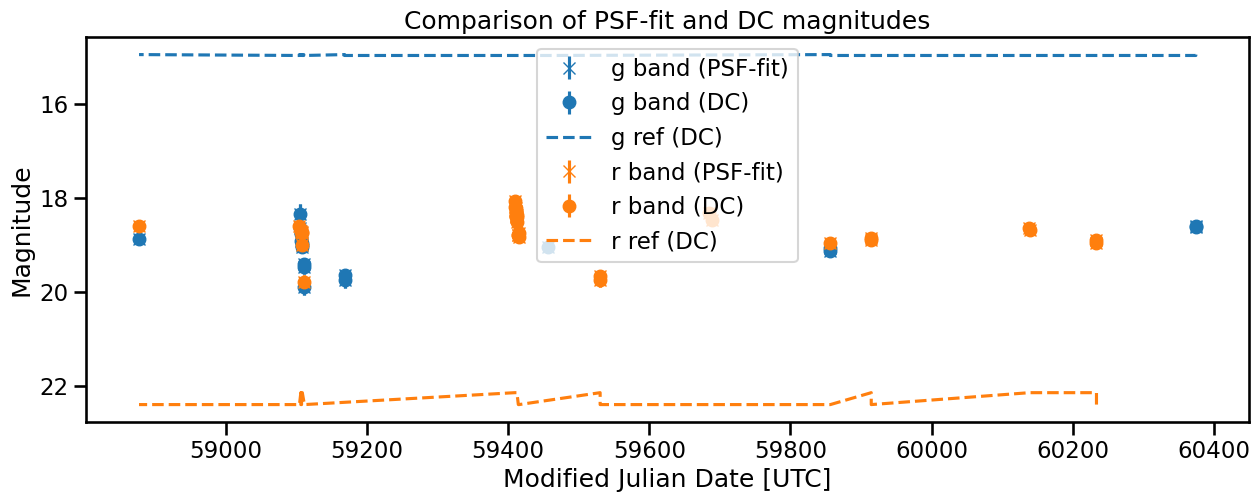

In [8]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt

    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:magpsf'],
        pdf_magpsf_valid[maskFilt]['i:sigmapsf'],
        ls = '', marker='x', 
        color=colordic[filt], 
        label='{} band (PSF-fit)'.format(filtdic[filt]),
    )
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc2'],
        pdf_magpsf_valid[maskFilt]['i:err_dc2'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:magnr'],
        ls = '--', 
        color=colordic[filt], 
        label='{} ref (DC)'.format(filtdic[filt]),
    )


ref_r = pdf_magpsf_valid['i:magnr']*(pdf_magpsf_valid['i:fid']==2)

ref_r = (ref_r[ref_r != 0]).mean()

ref_g = pdf_magpsf_valid['i:magnr']*(pdf_magpsf_valid['i:fid']==1)

ref_g = (ref_g[ref_g != 0]).mean()


print(ref_r, ref_g)

#plt.axhline(y=ref_r, color=colordic[2], linestyle='--')
#plt.axhline(y=ref_g, color=colordic[1], linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

In [9]:
from typing import Tuple
from fink_utils.photometry.conversion import apparent_flux

def dc_mag(
    magpsf: float,
    sigmapsf: float,
    magnr: float,
    sigmagnr: float,
    is_Source: bool,
    isdiffpos: int,
) -> Tuple[float, float]:
    """Compute apparent magnitude from difference magnitude supplied by ZTF
    Implemented according to p.107 of the ZTF Science Data System Explanatory Supplement
    https://irsa.ipac.caltech.edu/data/ZTF/docs/ztf_explanatory_supplement.pdf

    Parameters
    ----------
    magpsf,sigmapsf
        magnitude from PSF-fit photometry, and 1-sigma error
    magnr,sigmagnr
        magnitude of nearest source in reference image PSF-catalog
        within 30 arcsec and 1-sigma error
    isdiffpos
        t or 1 => candidate is from positive (sci minus ref) subtraction
        f or 0 => candidate is from negative (ref minus sci) subtraction

    Returns
    --------
    dc_mag: float
        Apparent magnitude
    dc_sigmag: float
        Error on apparent magnitude
    """
    
    if is_Source:
    
        dc_flux, dc_sigflux = apparent_flux(
            magpsf, sigmapsf, magnr, sigmagnr, isdiffpos, jansky=False
        )

        # apparent mag and its error from fluxes
        dc_mag = -2.5 * np.log10(dc_flux)
        dc_sigmag = dc_sigflux / dc_flux * 1.0857
        
        return dc_mag, dc_sigmag

        
#     else: 
#         dc_mag =  magpsf
#         dc_sigmag =  sigmapsf

    return magpsf, sigmapsf

In [10]:
pdf_magpsf_valid['is_Source'] = is_source_behind(pdf_magpsf_valid['i:distnr'])

In [11]:
mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                pdf_magpsf_valid['i:magpsf'].astype(float).values,
                pdf_magpsf_valid['i:sigmapsf'].astype(float).values,
                pdf_magpsf_valid['i:magnr'].astype(float).values,
                pdf_magpsf_valid['i:sigmagnr'].astype(float).values,
                pdf_magpsf_valid['is_Source'].values,
                pdf_magpsf_valid['i:isdiffpos'].values
            )
        ]
    )
    
pdf_magpsf_valid['i:mag_dc'] = mag_dc
pdf_magpsf_valid['i:err_dc'] = err_dc

In [12]:
pdf_magpsf_valid[['i:mag_dc','i:mag_dc2','i:distnr','is_Source', 'i:magpsf']]

,i:mag_dc,i:mag_dc2,i:distnr,is_Source,i:magpsf
0,18.608889,18.608889,10.623923,False,18.608889
1,18.596912,18.596912,10.864206,False,18.596912
18,18.906367,18.951159,0.962589,True,18.951159
19,18.832034,18.885036,1.264779,True,18.885036
59,18.630013,18.673832,1.241475,True,18.673832
65,18.606952,18.649832,1.249515,True,18.649832
74,18.859148,18.901995,1.047248,True,18.901995
75,18.801187,18.852669,1.249208,True,18.852669
113,18.918976,18.964302,1.013191,True,18.964302
114,19.065886,19.065886,10.823056,False,19.065886


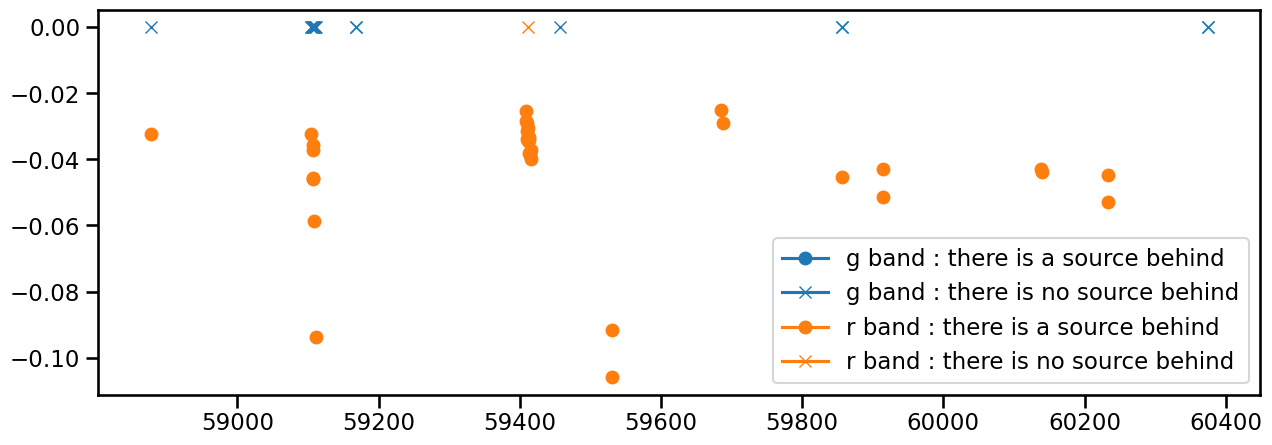

In [13]:
fig = plt.figure(figsize=(15, 5))

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt
    
    plt.plot([], [], color=colordic[filt], marker='o', label=f'{filtdic[filt]} band : there is a source behind')
    plt.plot([], [], color=colordic[filt], marker='x', label=f'{filtdic[filt]} band : there is no source behind')

    for idx, row in pdf_magpsf_valid[maskFilt].iterrows():
        # Determine marker based on is_Source for each point
        marker = 'o' if row['is_Source'] else 'x' 
        
#         plt.scatter(row['mjd'],
#                     row['i:distnr'], marker=marker, color=colordic[filt])
        plt.plot(
                row['i:jd'] - 2400000.5,
                row['i:mag_dc'] - row['i:mag_dc2'],
                marker=marker, 
                color=colordic[filt]
        )
plt.legend()